In [206]:
import kagglehub

path = kagglehub.dataset_download("raykleptzo/classification-data-apples-oranges")

print("Path to dataset files:", path)
!mv /root/.cache/kagglehub/datasets/raykleptzo/classification-data-apples-oranges/versions/1/apples_and_oranges.csv /content/

Path to dataset files: /root/.cache/kagglehub/datasets/raykleptzo/classification-data-apples-oranges/versions/1
mv: cannot stat '/root/.cache/kagglehub/datasets/raykleptzo/classification-data-apples-oranges/versions/1/apples_and_oranges.csv': No such file or directory


In [207]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('apples_and_oranges.csv')
training_set,test_set = train_test_split(data,test_size=0.2,random_state=1)
X_train = np.array(training_set.iloc[:,0:2].values).astype("float")
y_train = training_set.iloc[:,2].values
X_test = np.array(test_set.iloc[:,0:2].values).astype("float")
y_test = test_set.iloc[:,2].values

lb = LabelEncoder()
y_train = np.array(lb.fit_transform(y_train)).astype("float")
y_test = np.array(lb.fit_transform(y_test)).astype("float")

print(X_train[0:5])
print(y_train[0:5])

[[74.    5.5 ]
 [67.    4.01]
 [72.    5.72]
 [75.    5.25]
 [73.    5.78]]
[0. 1. 0. 0. 0.]


In [208]:
class KNN:
  def __init__(self, x, y, k):
    self.x = x
    self.y = y
    self.k = k
    pass

  def predict(self, x):
    distances = self.calculate_distances(x)
    nn = distances[:self.k]
    labels = [n[1] for n in nn]
    return np.bincount(labels).argmax()

  def euclidean_distance(self, x, y):
    return np.sqrt(np.sum((x - y) ** 2))

  def calculate_distances(self, x):
    distances = []
    for i in range(len(self.x)):
      distance = self.euclidean_distance(x, self.x[i])
      distances.append((distance, self.y[i]))
    distances.sort(key=lambda x: x[0])
    return distances

  def confusion_matrix(self, X_test, y_test):
    num_classes = int(max(np.max(self.y), np.max(y_test)) + 1)

    cm = np.zeros((num_classes, num_classes), dtype=int)

    y_pred = [self.predict(X_test[i]) for i in range(len(X_test))]

    for true, pred in zip(y_test, y_pred):
        cm[int(true), int(pred)] += 1

    return cm


In [209]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class SVM:
    def __init__(self, x, y, learning_rate=0.001, c=0.01):
        self.y = np.where(y <= 0, -1, 1)
        self.x = scaler.fit_transform(x)
        self.lr = learning_rate
        self.c = c
        self.w = np.zeros(x.shape[1])
        self.b = 0

    def fit(self, epoch):
        for e in range(epoch):
            for idx, x_i in enumerate(self.x):
                condition = self.y[idx] * self._predict(x_i) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.c * self.w)
                else:
                    self.w -= self.lr * (2 * self.c * self.w - np.dot(x_i, self.y[idx]))
                    self.b -= self.lr * self.y[idx]
            if e % 100 == 0:
              print("Epoch:",e)
        else:
          print(f"Training finished,weight = {self.w}, bias = {self.b}")
    def _predict(self, x):
        return np.dot(x, self.w) - self.b
    def predict(self, X):
        return np.sign(self._predict(X))

    def confusion_matrix(self, X_test, y_test):
      X_test = scaler.transform(X_test)
      y_test = np.where(y_test <= 0, -1, 1)
      num_classes = int(max(np.max(self.y), np.max(y_test)) + 1)

      cm = np.zeros((num_classes, num_classes), dtype=int)

      y_pred = [self.predict(X_test[i]) for i in range(len(X_test))]

      y_pred_transformed = np.where(np.array(y_pred) == -1, 0, y_pred)
      y_test_transformed = np.where(y_test == -1, 0, y_test)

      for true, pred in zip(y_test_transformed, y_pred_transformed):
          cm[int(true), int(pred)] += 1

      return cm

In [210]:
def test_knn(x_train, y_train, x_test, y_test):
  print("KNN Test")
  knn = KNN(x_train, y_train, 3)
  cm = knn.confusion_matrix(x_test, y_test)
  pred = knn.predict(x_test[0])
  print("Input:", x_test[0])
  print("Predicted:", pred)
  print("Confusion Matrix:\n", cm)

test_knn(X_train, y_train, X_test, y_test)

KNN Test
Input: [65.    4.09]
Predicted: 1
Confusion Matrix:
 [[3 0]
 [1 4]]


In [211]:
def test_svm(x_train, y_train, x_test, y_test):
  svm = SVM(x_train, y_train)
  svm.fit(1000)
  cm = svm.confusion_matrix(x_test, y_test)
  pred = svm.predict(x_test[0])
  print("Input:", x_test[0])
  print("Predicted:", pred)
  print("Confusion Matrix:\n", cm)

test_svm(X_train, y_train, X_test, y_test)

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Training finished,weight = [-0.86247525 -1.38716885], bias = -0.1170000000000001
Input: [65.    4.09]
Predicted: -1.0
Confusion Matrix:
 [[3 0]
 [0 5]]


In [212]:
X_flatted = X_train.flatten()

choices = np.random.choice(X_flatted.size, np.random.randint(1, X_flatted.size), replace = False)

X_flatted[choices] = np.nan
X_train_with_nan = X_flatted.reshape(X_train.shape)
X_train_with_nan

array([[74.  ,  5.5 ],
       [67.  ,  4.01],
       [72.  ,  5.72],
       [75.  ,  5.25],
       [  nan,  5.78],
       [69.  ,  4.76],
       [73.  ,  5.17],
       [74.  ,  5.25],
       [67.  ,  4.7 ],
       [74.  ,   nan],
       [73.  ,  5.79],
       [69.  ,  4.11],
       [  nan,  4.08],
       [67.  ,  4.25],
       [68.  ,  4.83],
       [66.  ,  4.13],
       [67.  ,  4.18],
       [71.  ,  5.35],
       [70.  ,  5.56],
       [68.  ,  4.47],
       [  nan,  5.11],
       [70.  ,  5.59],
       [69.  ,  4.21],
       [69.  ,  4.66],
       [69.  ,  4.39],
       [65.  ,   nan],
       [73.  ,  5.68],
       [70.  ,  5.47],
       [65.  ,  4.27],
       [74.  ,  5.36],
       [74.  ,  5.53],
       [74.  ,  5.48]])

In [213]:
test_knn(X_train_with_nan, y_train, X_test, y_test)

KNN Test
Input: [65.    4.09]
Predicted: 1
Confusion Matrix:
 [[3 0]
 [1 4]]


In [214]:
try:
  test_svm(X_train_with_nan, y_train, X_test, y_test)
except Exception as e:
  print(e)

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Training finished,weight = [nan nan], bias = 1.9999999999998908
cannot convert float NaN to integer


In [215]:
X_train_with_mean = X_train_with_nan.copy()
col_means = np.nanmean(X_train, axis=0)
inds = np.where(np.isnan(X_train_with_nan))
X_train_with_mean[inds] = np.take(col_means, inds[1])
X_train_with_mean

array([[74.      ,  5.5     ],
       [67.      ,  4.01    ],
       [72.      ,  5.72    ],
       [75.      ,  5.25    ],
       [70.375   ,  5.78    ],
       [69.      ,  4.76    ],
       [73.      ,  5.17    ],
       [74.      ,  5.25    ],
       [67.      ,  4.7     ],
       [74.      ,  4.948125],
       [73.      ,  5.79    ],
       [69.      ,  4.11    ],
       [70.375   ,  4.08    ],
       [67.      ,  4.25    ],
       [68.      ,  4.83    ],
       [66.      ,  4.13    ],
       [67.      ,  4.18    ],
       [71.      ,  5.35    ],
       [70.      ,  5.56    ],
       [68.      ,  4.47    ],
       [70.375   ,  5.11    ],
       [70.      ,  5.59    ],
       [69.      ,  4.21    ],
       [69.      ,  4.66    ],
       [69.      ,  4.39    ],
       [65.      ,  4.948125],
       [73.      ,  5.68    ],
       [70.      ,  5.47    ],
       [65.      ,  4.27    ],
       [74.      ,  5.36    ],
       [74.      ,  5.53    ],
       [74.      ,  5.48    ]])

In [216]:
test_knn(X_train_with_mean, y_train, X_test, y_test)

KNN Test
Input: [65.    4.09]
Predicted: 1
Confusion Matrix:
 [[3 0]
 [1 4]]


In [217]:
test_svm(X_train_with_mean, y_train, X_test, y_test)

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Training finished,weight = [-0.93760545 -1.233349  ], bias = -0.016000000000000014
Input: [65.    4.09]
Predicted: -1.0
Confusion Matrix:
 [[3 0]
 [0 5]]


In [218]:
import matplotlib.pyplot as plt
knn_cm = KNN(X_train, y_train, k=3).confusion_matrix(X_test, y_test)
svm_cm = SVM(X_train, y_train)
svm_cm.fit(1000)
svm_cm = svm_cm.confusion_matrix(X_test, y_test)

knn_nan_cm = KNN(X_train_with_nan, y_train, k=3).confusion_matrix(X_test, y_test)
try:
  svm_nan_cm = SVM(X_train_with_nan, y_train)
  svm_nan_cm.fit(1000)
  svm_nan_cm = svm_nan_cm.confusion_matrix(X_test, y_test)
except Exception as e:
  print(e)

knn_mean_cm = KNN(X_train_with_mean, y_train, k=3).confusion_matrix(X_test, y_test)
svm_mean_cm = SVM(X_train_with_mean, y_train)
svm_mean_cm.fit(1000)
svm_mean_cm = svm_mean_cm.confusion_matrix(X_test, y_test)

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Training finished,weight = [-0.86247525 -1.38716885], bias = -0.1170000000000001
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Training finished,weight = [nan nan], bias = 1.9999999999998908
cannot convert float NaN to integer
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Training finished,weight = [-0.93760545 -1.233349  ], bias = -0.016000000000000014


In [219]:
def plot_confusion_matrix(cm, title, ax):
    ax.matshow(cm, cmap='Blues', alpha=0.75)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

Image data of dtype object cannot be converted to float


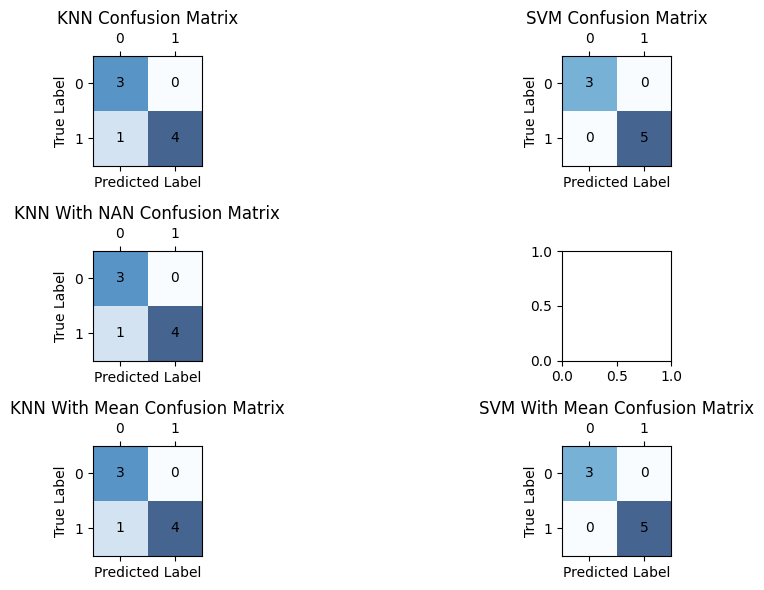

In [220]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

plot_confusion_matrix(knn_cm, title="KNN Confusion Matrix", ax=axes[0,0])

plot_confusion_matrix(svm_cm, title="SVM Confusion Matrix", ax=axes[0,1])

plot_confusion_matrix(knn_nan_cm, title="KNN With NAN Confusion Matrix", ax=axes[1,0])

try:
  plot_confusion_matrix(svm_nan_cm, title="SVM With NAN Confusion Matrix", ax=axes[1,1])
except Exception as e:
  print(e)

plot_confusion_matrix(knn_mean_cm, title="KNN With Mean Confusion Matrix", ax=axes[2,0])

plot_confusion_matrix(svm_mean_cm, title="SVM With Mean Confusion Matrix", ax=axes[2,1])

plt.tight_layout()
plt.show()